In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint
import logging, os, tempfile, time, gym
df_train = pd.read_hdf('data/df_train.hf',key='train')
df_test = pd.read_hdf('data/df_test.hf',key='test')
df_train.head()

Pair                        BTC                                      \
Price                     close        high         low        open   
date                                                                  
2016-12-31 23:00:00  965.000000  965.000000  962.859985  964.000000   
2016-12-31 23:30:00  966.173706  966.614990  963.000000  964.000000   
2017-01-01 00:00:00  966.150024  966.150024  961.700012  965.000000   
2017-01-01 00:30:00  964.133240  965.668152  962.880005  962.880005   
2017-01-01 01:00:00  965.854980  965.855042  964.133240  964.133240   

Pair                                                ETH                      \
Price                      volume quoteVolume     close      high       low   
date                                                                          
2016-12-31 23:00:00   3687.031982    3.824598  7.980005  8.030000  7.980000   
2016-12-31 23:30:00   3178.871826    3.293368  8.008506  8.038314  8.002000   
2017-01-01 00:00:00  11900.677734   12.348251  8.184482  8.232000  8.044822   
2017-01-01 00:30:00   2738.659912    2.842460  8.229053  8.242145  8.177586   
2017-01-01 01:00:00   1032.527344    1.069114  8.242145  8.242145  8.213986   

Pair                              ...            LTC                        \
Price                    open     ...            low      open      volume   
date                              ...                                        
2016-12-31 23:00:00  7.980000     ...       4.341458  4.341458    0.000000   
2016-12-31 23:30:00  8.030000     ...       4.346551  4.346551   14.047211   
2017-01-01 00:00:00  8.044822     ...       4.335165  4.349505   92.139870   
2017-01-01 00:30:00  8.177586     ...       4.395621  4.395621  585.349243   
2017-01-01 01:00:00  8.216482     ...       4.413020  4.413020    0.000000   

Pair                                  XRP                                \
Price               quoteVolume     close      high       low      open   
date                                                                      
2016-12-31 23:00:00    0.000000  0.006511  0.006511  0.006486  0.006486   
2016-12-31 23:30:00    3.229594  0.006486  0.006506  0.006484  0.006506   
2017-01-01 00:00:00   21.197990  0.006487  0.006487  0.006482  0.006482   
2017-01-01 00:30:00  131.855743  0.006487  0.006487  0.006487  0.006487   
2017-01-01 01:00:00    0.000000  0.006498  0.006498  0.006481  0.006481   

Pair                                         
Price                   volume  quoteVolume  
date                                         
2016-12-31 23:00:00   6.339470   976.828857  
2016-12-31 23:30:00   0.009873     1.522276  
2017-01-01 00:00:00  10.177060  1569.505249  
2017-01-01 00:30:00   0.000000     0.000000  
2017-01-01 01:00:00  15.481316  2386.927490  

[5 rows x 24 columns]

In [2]:
from management.environments.portfolio import PortfolioEnv
from management.util import MDD, sharpe, softmax
from management.wrappers import SoftmaxActions, \
TransposeHistory, ConcatStates
import gym
steps = 1000
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
        reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env) # softmax --> action ouptut sum up to 1
    env = DeepRLWrapper(env)
    return env

def task_fn_test():
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((6, 51, 4), (6, 51, 4))

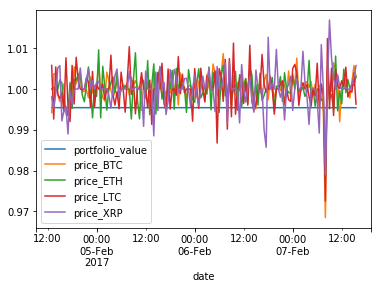

In [3]:
infos = []
for _ in range(150):
    action = np.array([10,0,0,0,0])
    new_state, reward, done, info = task.step(action)
    infos.append(info)

test = pd.DataFrame(infos)

test['date'] = pd.to_datetime(test['date'], unit='s')
test = test.set_index('date')

# portfolio_value: p1

test[['portfolio_value', 'price_BTC', 
      'price_ETH', 'price_LTC','price_XRP'   
     ]].plot()

In [4]:
test.head()

,cost,log_return,market_return,market_value,portfolio_value,price_BTC,price_ETH,price_LTC,price_USD,price_XRP,rate_of_return,reward,steps,weight_BTC,weight_ETH,weight_LTC,weight_USD,weight_XRP,weights_mean,weights_std
date,,,,,,,,,,,,,,,,,,,,
2017-02-04 13:00:00,2.010510e-03,-2.556369e-03,0.999613,0.997026,0.995441,0.994204,1.000000,1.005790,1.0,0.998070,-2.553105e-03,-2.556369e-06,3,0.000045,0.000045,0.000045,0.999818,0.000045,0.2,0.399909
2017-02-04 13:30:00,1.851175e-09,-4.638788e-07,0.998405,0.995435,0.995440,1.003722,1.000447,0.992645,1.0,0.995211,-4.638788e-07,-4.638788e-10,4,0.000045,0.000045,0.000045,0.999818,0.000045,0.2,0.399909
2017-02-04 14:00:00,1.196450e-09,2.448765e-07,1.001525,0.996953,0.995440,1.003655,0.999555,1.005429,1.0,0.998986,2.448765e-07,2.448765e-10,5,0.000045,0.000045,0.000045,0.999818,0.000045,0.2,0.399909
2017-02-04 14:30:00,8.945019e-10,1.013337e-08,1.000489,0.997441,0.995440,0.998548,1.000000,0.998733,1.0,1.005164,1.013337e-08,1.013337e-11,6,0.000045,0.000045,0.000045,0.999818,0.000045,0.2,0.399909
2017-02-04 15:00:00,1.508807e-09,1.896416e-08,1.000531,0.997970,0.995441,0.996955,1.002238,0.997724,1.0,1.005737,1.896416e-08,1.896416e-11,7,0.000045,0.000045,0.000045,0.999818,0.000045,0.2,0.399909


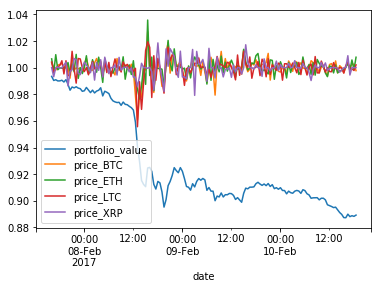

In [5]:
# create a random agent
infos = []
for _ in range(150):
    action = task.action_space.sample() 
    new_state, reward, done, info = task.step(action)
    infos.append(info)

test = pd.DataFrame(infos)

test['date'] = pd.to_datetime(test['date'], unit='s')
test = test.set_index('date')

# portfolio_value: p1

test[['portfolio_value', 'price_BTC', 
      'price_ETH', 'price_LTC','price_XRP'   
     ]].plot()

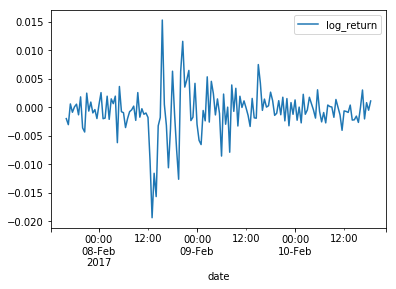

In [6]:
test[['log_return']].plot()

In [7]:
test.head()

,cost,log_return,market_return,market_value,portfolio_value,price_BTC,price_ETH,price_LTC,price_USD,price_XRP,rate_of_return,reward,steps,weight_BTC,weight_ETH,weight_LTC,weight_USD,weight_XRP,weights_mean,weights_std
date,,,,,,,,,,,,,,,,,,,,
2017-02-07 16:00:00,0.002022,-0.002023,1.002901,1.008022,0.993416,1.003721,1.006573,1.004217,1.0,0.999995,-0.002021,-2.023379e-06,153,0.155134,0.244319,0.262529,0.191061,0.146957,0.2,0.046434
2017-02-07 16:30:00,0.000304,-0.003084,0.997225,1.005226,0.990356,1.000000,0.996292,0.996742,1.0,0.993093,-0.003080,-3.084291e-06,154,0.183147,0.190460,0.272324,0.238203,0.115866,0.2,0.053186
2017-02-07 17:00:00,0.000781,0.000553,1.001441,1.006674,0.990904,0.998099,1.009732,0.999374,1.0,1.000000,0.000553,5.526345e-07,155,0.113694,0.256188,0.242608,0.121561,0.265949,0.2,0.067710
2017-02-07 17:30:00,0.000944,-0.000910,1.000241,1.006917,0.990003,1.001905,0.998405,1.000497,1.0,1.000399,-0.000909,-9.098210e-07,156,0.227391,0.162226,0.223194,0.272090,0.115098,0.2,0.054991
2017-02-07 18:00:00,0.000788,0.000038,1.000684,1.007606,0.990040,1.002376,0.999838,1.001611,1.0,0.999595,0.000038,3.772868e-08,157,0.130833,0.291558,0.191028,0.214969,0.171612,0.2,0.053437


In [8]:
# test on algo
import sys
import gym
import numpy as np
from scipy.stats import norm
from keras.layers import Dense, Input, Lambda, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

EPISODES = 3000

# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = True
        self.load_model = False
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # get gym environment name
        # these are hyper parameters for the A3C
        self.actor_lr = 0.0001
        self.critic_lr = 0.001
        self.discount_factor = .9
        self.hidden1, self.hidden2 = 24, 24

        # create model for actor and critic network
        self.actor, self.critic = self.build_model()

        # method for training actor and critic network
        self.optimizer = [self.actor_optimizer(), self.critic_optimizer()]

        if self.load_model:
            self.actor.load_weights("cartpole_actor.h5")
            self.critic.load_weights("cartpole_critic.h5")

    def build_model(self):
        state = Input(batch_shape=((None,) + self.state_size))
        actor_input = Dense(30, input_dim=self.state_size, activation='relu',
        kernel_initializer='he_uniform')(state)
        # -------------------------------------------
        mu_0 = Dense(self.action_size, activation='tanh',
        kernel_initializer='he_uniform')(actor_input)
        mu_0 = Flatten()(mu_0)
        mu_0 = Dense(100, activation='relu')(mu_0)
        mu_0 = Dense(5, activation='relu')(mu_0)
        # -------------------------------------------
        sigma_0 = Dense(self.action_size, activation='softplus',
        kernel_initializer='he_uniform')(actor_input)
        sigma_0 = Flatten()(sigma_0)
        sigma_0 = Dense(100, activation='relu')(sigma_0)
        sigma_0 = Dense(5, activation='relu')(sigma_0)
        # -------------------------------------------       
        mu = Lambda(lambda x: x * 2)(mu_0)
        sigma = Lambda(lambda x: x + 0.0001)(sigma_0)

        critic_input = Dense(30, input_dim=self.state_size,
        activation='relu', kernel_initializer='he_uniform')(state)
        # value_hidden = Dense(self.hidden2, activation='relu')(critic_input)
        state_value = Dense(1, activation='linear',
        kernel_initializer='he_uniform')(critic_input)

        actor = Model(inputs=state, outputs=(mu, sigma))
        critic = Model(inputs=state, outputs=state_value)

        actor._make_predict_function()
        critic._make_predict_function()

        actor.summary()
        critic.summary()

        return actor, critic

    def actor_optimizer(self):
        action = K.placeholder(shape=(None, 1))
        advantages = K.placeholder(shape=(None, 1))

        # mu = K.placeholder(shape=(None, self.action_size))
        # sigma_sq = K.placeholder(shape=(None, self.action_size))

        mu, sigma_sq = self.actor.output

        pdf = 1. / K.sqrt(2. * np.pi * sigma_sq) * K.exp(-K.square(action - mu) / \
        (2. * sigma_sq))
        log_pdf = K.log(pdf + K.epsilon())
        entropy = K.sum(0.5 * (K.log(2. * np.pi * sigma_sq) + 1.))

        exp_v = log_pdf * advantages

        exp_v = K.sum(exp_v + 0.01 * entropy)
        actor_loss = -exp_v

        optimizer = Adam(lr=self.actor_lr)
        updates = optimizer.get_updates(self.actor.trainable_weights,
        [], actor_loss)

        train = K.function([self.actor.input, action, advantages],
        [], updates=updates)
        return train

    # make loss function for Value approximation
    def critic_optimizer(self):
        discounted_reward = K.placeholder(shape=(None, 1))

        value = self.critic.output

        loss = K.mean(K.square(discounted_reward - value))

        optimizer = Adam(lr=self.critic_lr)
        updates = optimizer.get_updates(self.critic.trainable_weights,
        [], loss)
        train = K.function([self.critic.input, discounted_reward], [],
        updates=updates)
        return train

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        mu, sigma_sq = self.actor.predict(state)
        # sigma_sq = np.log(np.exp(sigma_sq + 1))
        epsilon = np.random.randn(self.action_size)
        # action = norm.rvs(loc=mu, scale=sigma_sq,size=1)
        action = mu + np.sqrt(sigma_sq) * epsilon
        action = action.reshape(-1,)
        #action = np.clip(action, -2, 2)
        
        return action

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        print("Value shape: ", value.shape, next_value.shape)

        if done:
            advantages[0] = reward - value
            target[0][0] = reward
        else:
            advantages[0] = reward + self.discount_factor * \
            (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.optimizer[0]([state, action, advantages])
        self.optimizer[1]([state, target])

f:\dsba\t2\advanc~1\final\test\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
task.action_space.shape

(5,)

In [10]:
task.state_dim

(6, 51, 4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 6, 4, 51, 4)       78        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 4, 3, 6)        1182      
_________________________________________________________________
flatten_1 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2165      
Total params: 3,425
Trainable params: 3,425
Non-trainable params: 0
_________________________________________________________________
None
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  (None, 4, 6, 51, 4)  0               

<IPython.core.display.Javascript object>


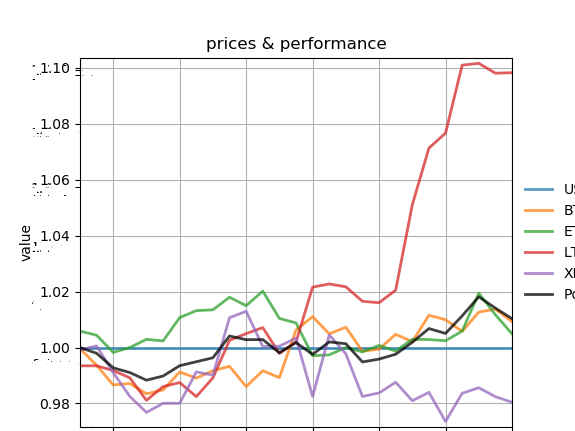

<IPython.core.display.Javascript object>


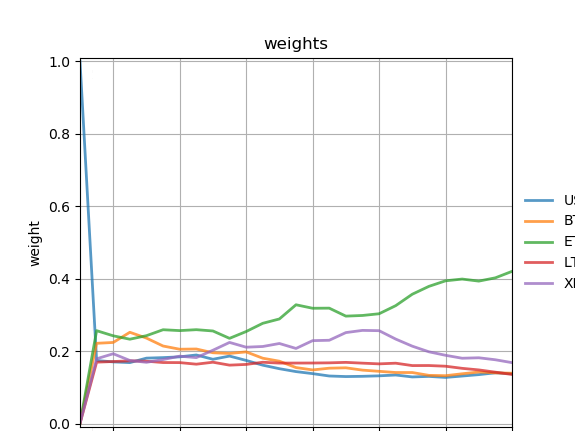

<IPython.core.display.Javascript object>


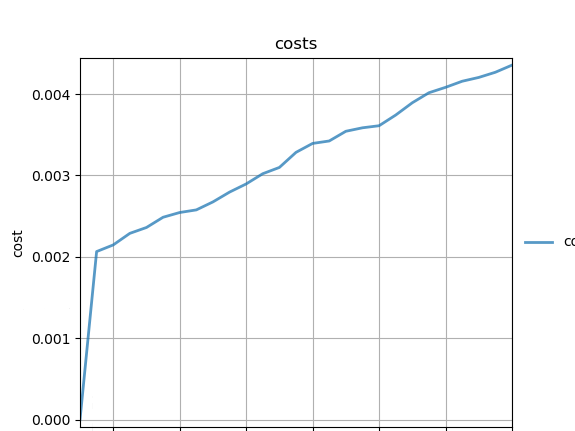

   100/50000: episode: 1, duration: 27.990s, episode steps: 100, steps per second: 4, episode reward: 0.150, mean reward: 0.001 [-0.046, 0.049], mean action: 0.120 [-0.345, 0.467], mean observation: 0.550 [-0.430, 1.033], loss: --, mean_absolute_error: --, mean_q: --


In [ ]:
from rl.agents.ddpg import DDPGAgent
import numpy as np
import gym
%matplotlib notebook
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, \
Concatenate, Conv3D, MaxPooling2D
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

WINDOW_LENGTH = 4

nb_actions= task.action_space.shape[0]
stride_time = task.state_dim[1] -1 -2
actor = Sequential()
actor.add(Conv3D(6, kernel_size=(3,1,1), 
                 input_shape= (WINDOW_LENGTH,) + task.observation_space.shape,
                 activation='relu', data_format="channels_first"))
actor.add(Conv3D(6, kernel_size=(1,1,49)))
actor.add(Flatten(input_shape=(WINDOW_LENGTH,) + task.observation_space.shape))
actor.add(Dense(5, activation='softmax'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(WINDOW_LENGTH,) + task.observation_space.shape, 
                          name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1000, window_length=WINDOW_LENGTH)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, 
                                          theta=.15, mu=0.1, sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, 
                  actor=actor, critic=critic, 
                  critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, 
                  nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, 
                  target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for 
# show, but this slows down training quite a lot. You can always safely 
# abort the training prematurely using Ctrl + C.
agent.fit(task, nb_steps=50000, visualize=True, 
          verbose=2, nb_max_episode_steps=100)

# After training is done, we save the final weights.
#agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)